In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json

# Define the path to your JSON file
file_path = '/content/drive/MyDrive/MasterThesis/Scenario1_distilbart_with_all_similarities_only_2.json'

# Open and load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

In [ ]:
!pip install language_tool_python
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from tqdm import tqdm
import nltk
import language_tool_python
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize LanguageTool
tool = language_tool_python.LanguageTool('en-US')

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Function to download images
def download_image(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# Enhanced preprocessing and feature extraction setup with data augmentation
model = resnet50(pretrained=True)
model.eval()
# Adding data augmentation to the transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def calculate_average_cosine_similarity(generated_caption, original_captions):
    similarities = [calculate_cosine_similarity(generated_caption, original) for original in original_captions]
    return sum(similarities) / len(similarities)

features = []
labels = []

for item in tqdm(data.values()):
    img_url = item['url']
    img = download_image(img_url)
    if img:
        img_t = transform(img).unsqueeze(0)  # Apply transformation with augmentation

        with torch.no_grad():
            feature = model(img_t)
        features.append(feature.numpy().flatten())

        blip_avg_cos_sim = calculate_average_cosine_similarity(item['generated_captions']['blip'], item['original_coco_captions'])
        gpt2_avg_cos_sim = calculate_average_cosine_similarity(item['generated_captions']['gpt2'], item['original_coco_captions'])

        label = 1 if blip_avg_cos_sim > gpt2_avg_cos_sim else 0
        labels.append(label)

features = np.array(features)
labels = np.array(labels)


INFO:language_tool_python.download_lt:Unzipping /tmp/tmpyvpphcbw.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the mo

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')




Epoch 1/20
28/28 [==============================] - 7s 13ms/step - loss: 0.7552 - accuracy: 0.5665
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.5358 - accuracy: 0.7099
Epoch 3/20
28/28 [==============================] - 0s 11ms/step - loss: 0.4849 - accuracy: 0.7580
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 0.3880 - accuracy: 0.8268
Epoch 5/20
28/28 [==============================] - 0s 9ms/step - loss: 0.3393 - accuracy: 0.8498
Epoch 6/20
28/28 [==============================] - 0s 14ms/step - loss: 0.2890 - accuracy: 0.8819
Epoch 7/20
28/28 [==============================] - 0s 11ms/step - loss: 0.2754 - accuracy: 0.8635
Epoch 8/20
28/28 [==============================] - 0s 11ms/step - loss: 0.2052 - accuracy: 0.9232
Epoch 9/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1641 - accuracy: 0.9392
Epoch 10/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1287 - accuracy: 0.9587
Epoch 11/2

FailedPreconditionError: /content/drive/MyDrive/MasterThesis/Scenario1_distilbart_with_all_similarities_only_2.json is not a directory

In [ ]:
model.save('/content/drive/MyDrive/MasterThesis/model_ann.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test Accuracy: 0.6881


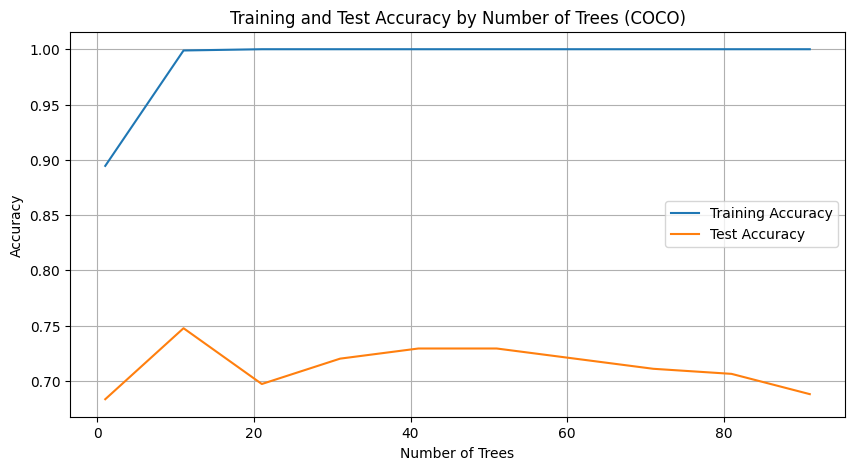

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Variables to store accuracies
train_accuracies = []
test_accuracies = []

# Number of trees to evaluate
n_estimators_range = range(1, 101, 10)  # From 1 to 100 trees, step by 10

for n_estimators in n_estimators_range:
    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = rf_classifier.predict(X_train)
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy by Number of Trees (COCO)')
plt.legend()
plt.grid(True)
plt.show()


Test Accuracy: 0.6789


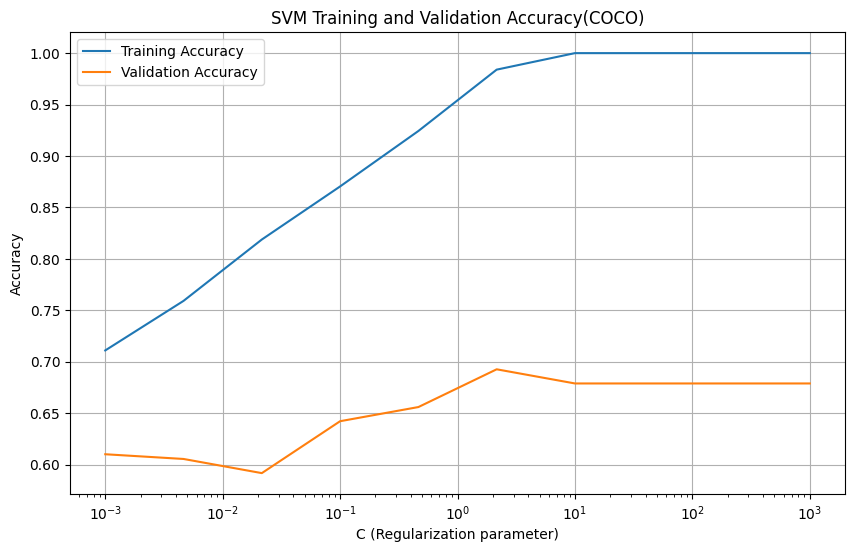

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Values of C to iterate over
C_values = np.logspace(-3, 3, 10)  # Logarithmically spaced values
train_accuracies = []
validation_accuracies = []

for C in C_values:
    svm_classifier = SVC(kernel='linear', C=C, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)

    # Record the accuracy on the training set
    train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train_scaled))
    train_accuracies.append(train_accuracy)

    # Record the accuracy on the validation set
    validation_accuracy = accuracy_score(y_test, svm_classifier.predict(X_test_scaled))
    validation_accuracies.append(validation_accuracy)


# Predict on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, label='Validation Accuracy')
plt.title('SVM Training and Validation Accuracy(COCO)')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_svm_model = grid_search.best_estimator_

# Evaluate the best model found by grid search
y_pred_best = best_svm_model.predict(X_test_scaled)
print(f"Test Accuracy (Best Model): {accuracy_score(y_test, y_pred_best):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END .....................C=0.1, gamma=1, k